Steps to follow before running the python notebook:

1. Create a folder with the name "02718Project/Data/" in Google Drive. This code will save csv files at each checkpoint in the folder on the mounted Google Drive.


Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Installing Required Libraries

In [ ]:
! pip install rdkit
! pip install fastapi
! pip install kaleido
! pip install python-multipart
! pip install uvicorn
! pip install chembl_webresource_client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.8.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.8 MB/s eta 0:00:00
ERROR: pip's

Downloading PaDEL Descriptors Script

In [ ]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2023-12-04 20:36:38--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2023-12-04 20:36:38--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M   134MB/s    in 0.2s    

2023-12-04 20:36:39 (134 MB/s) - ‘padel.zip’ saved [25768637/25768637]

--2023-12-04 20:36:39--  https://github

In [ ]:
! unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

Importing Required Libraries

In [ ]:
import pandas as pd
from chembl_webresource_client.new_client import new_client
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
import xgboost as xgb

Getting VEGFR2 targets

In [ ]:
target = new_client.target
target_query = target.search('ChEMBL279')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P35968', 'xref_name': None, 'xre...",Homo sapiens,Vascular endothelial growth factor receptor 2,12.0,False,CHEMBL279,"[{'accession': 'P35968', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Homo sapiens,Vascular endothelial growth factor receptor 2 ...,5.0,False,CHEMBL2111409,"[{'accession': 'P35916', 'component_descriptio...",SELECTIVITY GROUP,9606
2,[],Homo sapiens,VEGF-receptor 2 and stem cell growth factor re...,5.0,False,CHEMBL2111428,"[{'accession': 'P10721', 'component_descriptio...",SELECTIVITY GROUP,9606
3,[],Homo sapiens,VEGF-receptor 2 and Fibroblast growth factor r...,5.0,False,CHEMBL2111434,"[{'accession': 'P35968', 'component_descriptio...",SELECTIVITY GROUP,9606
4,[],Homo sapiens,VEGF-receptor 2 and Fibroblast growth factor r...,5.0,False,CHEMBL2111439,"[{'accession': 'P35968', 'component_descriptio...",PROTEIN FAMILY,9606
5,[],Homo sapiens,VEGF-receptor 2 and PDGF-receptor beta (KDR an...,5.0,False,CHEMBL2111440,"[{'accession': 'P09619', 'component_descriptio...",SELECTIVITY GROUP,9606
6,[],Homo sapiens,Vascular endothelial growth factor receptor 1 ...,5.0,False,CHEMBL2111480,"[{'accession': 'P17948', 'component_descriptio...",SELECTIVITY GROUP,9606
7,[],Homo sapiens,Vascular endothelial growth factor receptor 2 ...,5.0,False,CHEMBL2111375,"[{'accession': 'P35968', 'component_descriptio...",SELECTIVITY GROUP,9606
8,[],Homo sapiens,TEL/KDR,5.0,False,CHEMBL4630759,"[{'accession': 'P35968', 'component_descriptio...",CHIMERIC PROTEIN,9606
9,[],Homo sapiens,Vascular endothelial growth factor receptor,4.0,False,CHEMBL2095227,"[{'accession': 'P17948', 'component_descriptio...",PROTEIN FAMILY,9606


Retrieving Bioactivity Data for Target "Vascular endothelial growth factor receptor 2"


In [ ]:
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL279'

Filtering the bioactivity data with reported IC50 bioactivity

In [ ]:
activity = new_client.activity
ic50filter = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [ ]:
df = pd.DataFrame.from_dict(ic50filter)
df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,32262,[],CHEMBL816964,Inhibition of tyrosine phosphorylation in cell...,B,None,None,BAO_0000190,...,Homo sapiens,Vascular endothelial growth factor receptor 2,9606,None,None,IC50,uM,UO_0000065,None,16.5
1,None,None,32269,[],CHEMBL816964,Inhibition of tyrosine phosphorylation in cell...,B,None,None,BAO_0000190,...,Homo sapiens,Vascular endothelial growth factor receptor 2,9606,None,None,IC50,uM,UO_0000065,None,20.0
2,None,None,32335,[],CHEMBL817617,Inhibition of Vascular endothelial growth fact...,B,None,None,BAO_0000190,...,Homo sapiens,Vascular endothelial growth factor receptor 2,9606,None,None,IC50,uM,UO_0000065,None,7.1
3,None,None,33033,[],CHEMBL812621,Inhibitory activity towards vascular endotheli...,B,None,None,BAO_0000190,...,Homo sapiens,Vascular endothelial growth factor receptor 2,9606,None,None,IC50,nM,UO_0000065,None,1880.0
4,None,None,33408,[],CHEMBL816964,Inhibition of tyrosine phosphorylation in cell...,B,None,None,BAO_0000190,...,Homo sapiens,Vascular endothelial growth factor receptor 2,9606,None,None,IC50,uM,UO_0000065,None,10.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14082,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24958850,[],CHEMBL5215100,Inhibition of VEGFR2 (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,Vascular endothelial growth factor receptor 2,9606,None,None,IC50,nM,UO_0000065,None,74.0
14083,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24958851,[],CHEMBL5215100,Inhibition of VEGFR2 (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,Vascular endothelial growth factor receptor 2,9606,None,None,IC50,nM,UO_0000065,None,54.0
14084,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24959152,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5215242,Inhibition of VEGFR-2 (unknown origin) using F...,B,None,None,BAO_0000190,...,Homo sapiens,Vascular endothelial growth factor receptor 2,9606,None,None,IC50,uM,UO_0000065,None,0.05
14085,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24959153,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5215242,Inhibition of VEGFR-2 (unknown origin) using F...,B,None,None,BAO_0000190,...,Homo sapiens,Vascular endothelial growth factor receptor 2,9606,None,None,IC50,uM,UO_0000065,None,0.08


Saving the raw bioactivity df to a csv

In [ ]:
df.to_csv('bioactivity_data_raw.csv', index=False)

In [ ]:
! cp /content/bioactivity_data_raw.csv /content/gdrive/MyDrive/02718Project/Data/

In [ ]:
data_path_raw = '/content/gdrive/MyDrive/02718Project/Data/bioactivity_data_raw.csv'

In [ ]:
df_raw = pd.read_csv(data_path_raw)

Removing missing data from IC50 and SMILES columns

In [ ]:
df_raw = df_raw.dropna(subset=['standard_value', 'canonical_smiles'])
df_raw

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,NaN,32262,[],CHEMBL816964,Inhibition of tyrosine phosphorylation in cell...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Vascular endothelial growth factor receptor 2,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,16.50
1,NaN,NaN,32269,[],CHEMBL816964,Inhibition of tyrosine phosphorylation in cell...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Vascular endothelial growth factor receptor 2,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,20.00
2,NaN,NaN,32335,[],CHEMBL817617,Inhibition of Vascular endothelial growth fact...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Vascular endothelial growth factor receptor 2,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,7.10
3,NaN,NaN,33033,[],CHEMBL812621,Inhibitory activity towards vascular endotheli...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Vascular endothelial growth factor receptor 2,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,1880.00
4,NaN,NaN,33408,[],CHEMBL816964,Inhibition of tyrosine phosphorylation in cell...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Vascular endothelial growth factor receptor 2,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,10.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14082,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24958850,[],CHEMBL5215100,Inhibition of VEGFR2 (unknown origin),B,NaN,NaN,BAO_0000190,...,Homo sapiens,Vascular endothelial growth factor receptor 2,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,74.00
14083,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24958851,[],CHEMBL5215100,Inhibition of VEGFR2 (unknown origin),B,NaN,NaN,BAO_0000190,...,Homo sapiens,Vascular endothelial growth factor receptor 2,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,54.00
14084,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24959152,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5215242,Inhibition of VEGFR-2 (unknown origin) using F...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Vascular endothelial growth factor receptor 2,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.05
14085,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24959153,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5215242,Inhibition of VEGFR-2 (unknown origin) using F...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Vascular endothelial growth factor receptor 2,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.08


Ccategorizing compounds into three groups: active, inactive, or intermediate.

The bioactivity data is measured in IC50 units, and compounds with values below 1000 nM are designated as active, those exceeding 10,000 nM are labeled as inactive, and values between 1,000 and 10,000 nM are classified as intermediate.

In [ ]:
bioactivity_class = []
for i in df_raw['standard_value']:
  if float(i) >= 10000:
    bioactivity_class.append("inactive")
  elif float(i) <= 1000:
    bioactivity_class.append("active")
  else:
    bioactivity_class.append("intermediate")

len(bioactivity_class)

13699

Getting only relevant columns

In [ ]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df_raw = df_raw[selection]
df_raw

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,16500.0
1,CHEMBL69960,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,20000.0
2,CHEMBL69638,Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1,7100.0
3,CHEMBL419526,c1ccc(-c2cnc(Nc3ccccn3)o2)cc1,1880.0
4,CHEMBL443268,Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...,10100.0
...,...,...,...
14082,CHEMBL3759186,COc1cc2ncnc(Nc3ccc(Br)cc3)c2cc1OCCCCCCC(=O)NO,74.0
14083,CHEMBL24828,COc1cc2/c(=N/c3ccc(Br)cc3F)nc[nH]c2cc1OCC1CCN(...,54.0
14084,CHEMBL5218459,COc1cc2ncnc(Oc3cccc(NC(=S)Nc4ccc(Cl)c(C(F)(F)F...,50.0
14085,CHEMBL5218990,COc1cc2ncnc(Sc3cccc(NC(=S)Nc4ccc(Br)c(C(F)(F)F...,80.0


In [ ]:
df_raw['bioactivity_class'] = bioactivity_class
df_raw

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,16500.0,inactive
1,CHEMBL69960,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,20000.0,inactive
2,CHEMBL69638,Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1,7100.0,intermediate
3,CHEMBL419526,c1ccc(-c2cnc(Nc3ccccn3)o2)cc1,1880.0,intermediate
4,CHEMBL443268,Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...,10100.0,inactive
...,...,...,...,...
14082,CHEMBL3759186,COc1cc2ncnc(Nc3ccc(Br)cc3)c2cc1OCCCCCCC(=O)NO,74.0,active
14083,CHEMBL24828,COc1cc2/c(=N/c3ccc(Br)cc3F)nc[nH]c2cc1OCC1CCN(...,54.0,active
14084,CHEMBL5218459,COc1cc2ncnc(Oc3cccc(NC(=S)Nc4ccc(Cl)c(C(F)(F)F...,50.0,active
14085,CHEMBL5218990,COc1cc2ncnc(Sc3cccc(NC(=S)Nc4ccc(Br)c(C(F)(F)F...,80.0,active


Saving the preprocessed bioactivity data to csv

In [ ]:
df_raw.to_csv('bioactivity_data_preprocessed.csv', index=False)

In [ ]:
! cp /content/bioactivity_data_preprocessed.csv /content/gdrive/MyDrive/02718Project/Data/

In [ ]:
data_path_prepro = '/content/gdrive/MyDrive/02718Project/Data/bioactivity_data_preprocessed.csv'
df_prepro = pd.read_csv(data_path_prepro)

Calculating the pIC50 values - converting IC50 to pIC50 (logarithmic scale for ease of interpretation)

In [ ]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value']:
        if i > 1000000000:
          i = 1000000000
        molar = i*(10**-9)
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50


    return input

In [ ]:
df_prepro = pIC50(df_prepro)
df_prepro

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,pIC50
0,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,16500.0,inactive,4.782516
1,CHEMBL69960,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,20000.0,inactive,4.698970
2,CHEMBL69638,Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1,7100.0,intermediate,5.148742
3,CHEMBL419526,c1ccc(-c2cnc(Nc3ccccn3)o2)cc1,1880.0,intermediate,5.725842
4,CHEMBL443268,Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...,10100.0,inactive,4.995679
...,...,...,...,...,...
13694,CHEMBL3759186,COc1cc2ncnc(Nc3ccc(Br)cc3)c2cc1OCCCCCCC(=O)NO,74.0,active,7.130768
13695,CHEMBL24828,COc1cc2/c(=N/c3ccc(Br)cc3F)nc[nH]c2cc1OCC1CCN(...,54.0,active,7.267606
13696,CHEMBL5218459,COc1cc2ncnc(Oc3cccc(NC(=S)Nc4ccc(Cl)c(C(F)(F)F...,50.0,active,7.301030
13697,CHEMBL5218990,COc1cc2ncnc(Sc3cccc(NC(=S)Nc4ccc(Br)c(C(F)(F)F...,80.0,active,7.096910


**Exploratory Data Analysis**

Plotting Frequency of each Bioactivity Class in the Dataset

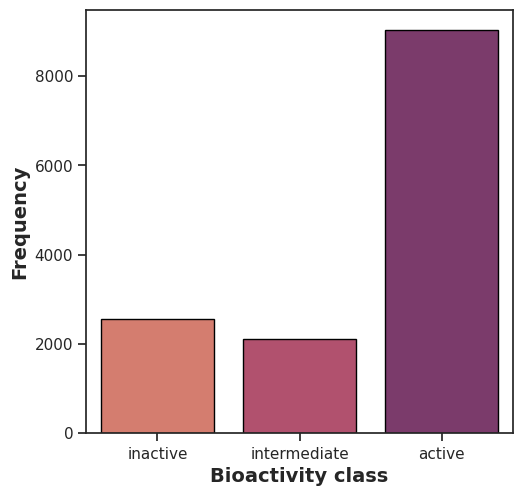

In [ ]:
sns.set(style='ticks')
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_prepro, edgecolor='black', palette='flare')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

Calculating the Lipinski Rule Of Five values with SMILES as input

In [ ]:
def lipinski(smiles, verbose=False):

    baseData= np.arange(1,1)
    i=0
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [ ]:
df_lipinski = lipinski(df_prepro.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,383.814,4.45034,3.0,4.0
1,482.903,3.61432,3.0,6.0
2,370.456,5.58790,1.0,5.0
3,237.262,3.48020,1.0,4.0
4,539.999,3.22822,3.0,7.0
...,...,...,...,...
13694,489.370,4.97920,3.0,7.0
13695,475.362,4.42610,1.0,5.0
13696,534.947,6.92040,2.0,6.0
13697,595.466,7.38840,2.0,6.0


In [ ]:
df_bioactivity_lipinski = pd.concat([df_prepro,df_lipinski], axis=1)
df_bioactivity_lipinski = df_bioactivity_lipinski[df_bioactivity_lipinski.bioactivity_class != 'intermediate']
df_bioactivity_lipinski

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,pIC50,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,16500.0,inactive,4.782516,383.814,4.45034,3.0,4.0
1,CHEMBL69960,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,20000.0,inactive,4.698970,482.903,3.61432,3.0,6.0
4,CHEMBL443268,Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...,10100.0,inactive,4.995679,539.999,3.22822,3.0,7.0
5,CHEMBL330621,Cc1ccc(Nc2ncc(-c3ccccc3)s2)nc1,19.0,active,7.721246,267.357,4.25712,1.0,4.0
6,CHEMBL304271,CCN(CC)CC(O)CNC(=O)c1cc(C)c(/C=C2\C(=O)Nc3ncnc...,360.0,active,6.443697,542.015,3.57442,5.0,7.0
...,...,...,...,...,...,...,...,...,...
13694,CHEMBL3759186,COc1cc2ncnc(Nc3ccc(Br)cc3)c2cc1OCCCCCCC(=O)NO,74.0,active,7.130768,489.370,4.97920,3.0,7.0
13695,CHEMBL24828,COc1cc2/c(=N/c3ccc(Br)cc3F)nc[nH]c2cc1OCC1CCN(...,54.0,active,7.267606,475.362,4.42610,1.0,5.0
13696,CHEMBL5218459,COc1cc2ncnc(Oc3cccc(NC(=S)Nc4ccc(Cl)c(C(F)(F)F...,50.0,active,7.301030,534.947,6.92040,2.0,6.0
13697,CHEMBL5218990,COc1cc2ncnc(Sc3cccc(NC(=S)Nc4ccc(Br)c(C(F)(F)F...,80.0,active,7.096910,595.466,7.38840,2.0,6.0


Mann Withney U Test to understand if our data is significantly different between the two classes

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_prepro[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_bioactivity_lipinski[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

pIC50
  Descriptor  Statistics    p  alpha                      Interpretation
0      pIC50  23083052.0  0.0   0.05  Different distribution (reject H0)

MW
  Descriptor  Statistics             p  alpha  \
0         MW  13494396.5  4.436677e-39   0.05   

                       Interpretation  
0  Different distribution (reject H0)  

LogP
  Descriptor  Statistics             p  alpha  \
0       LogP  13672649.0  3.317485e-46   0.05   

                       Interpretation  
0  Different distribution (reject H0)  

NumHDonors
   Descriptor  Statistics              p  alpha  \
0  NumHDonors  14726753.5  3.195162e-108   0.05   

                       Interpretation  
0  Different distribution (reject H0)  

NumHAcceptors
      Descriptor  Statistics             p  alpha  \
0  NumHAcceptors  10460279.0  2.439165e-13   0.05   

                       Interpretation  
0  Different distribution (reject H0)  



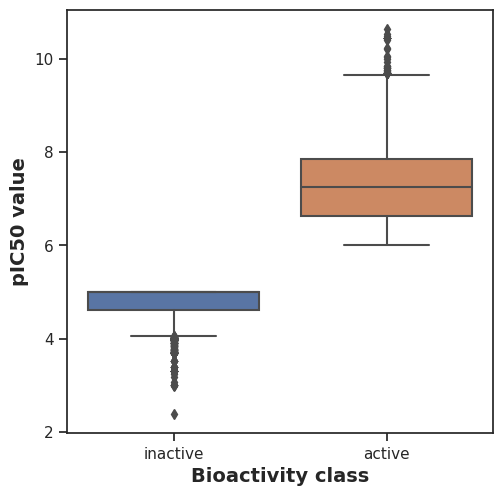

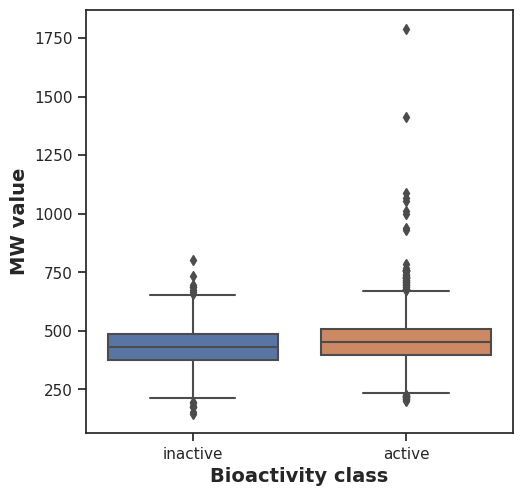

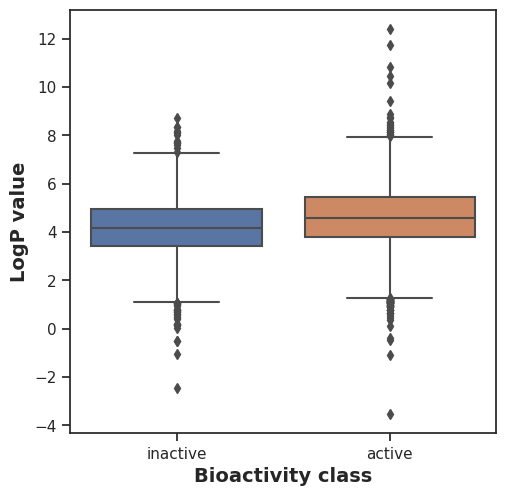

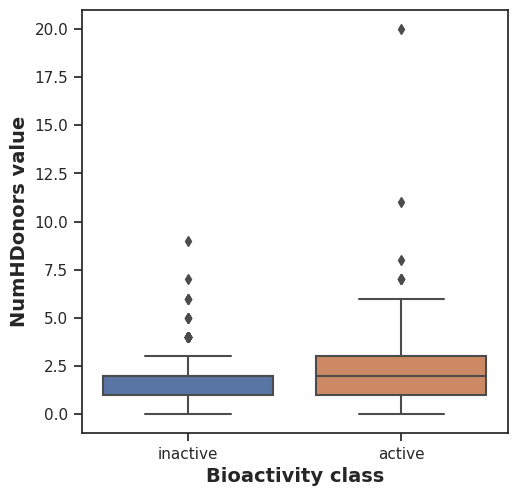

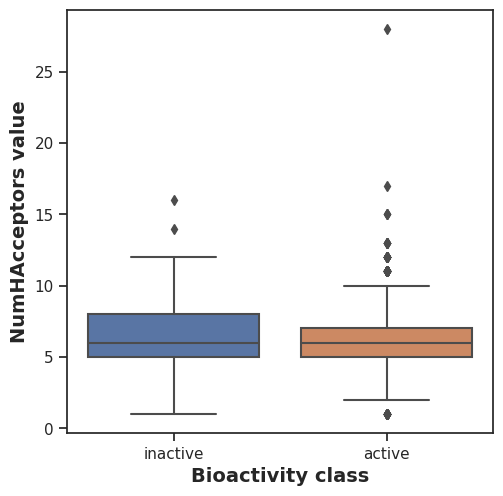

In [ ]:
for descriptor in df_bioactivity_lipinski.columns[4:]:
  print(descriptor)
  results = mannwhitney(descriptor)
  print(results)
  print()


  plt.figure(figsize=(5.5, 5.5))

  sns.boxplot(x = 'bioactivity_class', y = descriptor, data = df_bioactivity_lipinski)

  plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
  plt.ylabel(f'{descriptor} value', fontsize=14, fontweight='bold')

Filtering compounds based on Lipinski Rule of Five

In [ ]:
indices = []
for i, row in df_bioactivity_lipinski.iterrows():
  if row['MW'] <= 500 and row['LogP'] < 5 and row['NumHDonors'] <= 5 and row['NumHAcceptors'] <= 10:
    indices.append(i)

print(indices)
len(indices)

[0, 1, 5, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 21, 26, 28, 29, 31, 32, 33, 34, 37, 40, 41, 42, 43, 44, 47, 48, 51, 54, 56, 58, 60, 62, 65, 66, 69, 70, 71, 73, 74, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 124, 125, 132, 141, 143, 145, 146, 147, 149, 150, 151, 152, 157, 163, 164, 166, 167, 169, 174, 175, 178, 181, 188, 189, 199, 200, 201, 203, 206, 207, 208, 209, 210, 212, 214, 217, 218, 219, 220, 221, 222, 223, 224, 226, 227, 229, 230, 231, 234, 235, 236, 237, 238, 239, 242, 243, 244, 246, 247, 248, 249, 251, 253, 254, 256, 257, 258, 259, 260, 261, 263, 265, 266, 268, 269, 270, 271, 274, 277, 279, 280, 281, 285, 286, 287, 288, 289, 290, 291, 293, 297, 300, 301, 302, 304, 305, 307, 310, 313, 314, 315, 316, 317, 318, 320, 322, 325, 326, 328, 329, 333, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 3

6252

In [ ]:
df_bioactivity_lipinski = df_bioactivity_lipinski.loc[indices, :]
df_bioactivity_lipinski

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,pIC50,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,16500.0,inactive,4.782516,383.814,4.45034,3.0,4.0
1,CHEMBL69960,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,20000.0,inactive,4.698970,482.903,3.61432,3.0,6.0
5,CHEMBL330621,Cc1ccc(Nc2ncc(-c3ccccc3)s2)nc1,19.0,active,7.721246,267.357,4.25712,1.0,4.0
7,CHEMBL98896,c1ccc(-c2cnc(Nc3cnccn3)s2)cc1,23.0,active,7.638272,254.318,3.34370,1.0,5.0
8,CHEMBL98653,c1ccc(-c2cnc(Nc3cccnc3)s2)cc1,240.0,active,6.619789,253.330,3.94870,1.0,4.0
...,...,...,...,...,...,...,...,...,...
13690,CHEMBL514499,COc1cc2ncn(-c3cc(OCc4ccccc4C(F)(F)F)c(C(N)=O)s...,360.0,active,6.443697,477.464,4.80090,1.0,7.0
13691,CHEMBL3990456,Cn1cc(-c2[nH]c3cc(NC(=O)[C@H](N)C4CCCCC4)cc4c3...,8.0,active,8.096910,419.489,2.49180,4.0,6.0
13692,CHEMBL98,O=C(CCCCCCC(=O)Nc1ccccc1)NO,10000.0,inactive,5.000000,264.325,2.47110,3.0,3.0
13694,CHEMBL3759186,COc1cc2ncnc(Nc3ccc(Br)cc3)c2cc1OCCCCCCC(=O)NO,74.0,active,7.130768,489.370,4.97920,3.0,7.0


**QSAR Analysis**

Getting PaDeL descriptors for entire dataset

In [ ]:
selection = ['canonical_smiles','molecule_chembl_id']
df_prepro_selection = df_prepro[selection]
df_prepro_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
! cat molecule.smi | head -5
! cat molecule.smi | wc -l

Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c32)[nH]1	CHEMBL68920
Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(Nc3ccc(F)c(Cl)c3)c21	CHEMBL69960
Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1	CHEMBL69638
c1ccc(-c2cnc(Nc3ccccn3)o2)cc1	CHEMBL419526
Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2ncnc(Nc3ccc(F)c(Cl)c3)c21	CHEMBL443268
13699


In [ ]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [ ]:
! bash padel.sh

Streaming output truncated to the last 5000 lines.
Processing CHEMBL3983918 in molecule.smi (8701/13699). Average speed: 0.30 s/mol.
Processing CHEMBL3924172 in molecule.smi (8703/13699). Average speed: 0.30 s/mol.
Processing CHEMBL3975193 in molecule.smi (8702/13699). Average speed: 0.30 s/mol.
Processing CHEMBL3900551 in molecule.smi (8705/13699). Average speed: 0.30 s/mol.
Processing CHEMBL3921469 in molecule.smi (8704/13699). Average speed: 0.30 s/mol.
Processing CHEMBL3935838 in molecule.smi (8707/13699). Average speed: 0.30 s/mol.
Processing CHEMBL3891525 in molecule.smi (8706/13699). Average speed: 0.30 s/mol.
Processing CHEMBL3967761 in molecule.smi (8709/13699). Average speed: 0.30 s/mol.
Processing CHEMBL3977010 in molecule.smi (8708/13699). Average speed: 0.30 s/mol.
Processing CHEMBL3896249 in molecule.smi (8711/13699). Average speed: 0.30 s/mol.
Processing CHEMBL3893556 in molecule.smi (8710/13699). Average speed: 0.30 s/mol.
Processing CHEMBL3955385 in molecule.smi (8713/

In [ ]:
! cp /content/descriptors_output_all.csv /content/gdrive/MyDrive/02718Project/Data/

In [ ]:
data_path_padel_all = '/content/gdrive/MyDrive/02718Project/Data/descriptors_output_all.csv'
df_padel = pd.read_csv(data_path_padel_all)

In [ ]:
df_padel_desc = df_padel.drop(columns=['Name'])
df_padel_desc

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13694,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
13695,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
13696,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
13697,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Input for ML model

In [ ]:
X = df_padel_desc
y = df_prepro['pIC50']

X.shape

(13699, 881)

In [ ]:
y.shape

(13699,)

Splitting the dataset - train (80%), test (20%)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10959, 881), (10959,), (2740, 881), (2740,))

Training and Prediction using XGBRegressor

In [ ]:
model = xgb.XGBRegressor(n_estimators=100)
model.fit(X_train, y_train)
r2 = model.score(X_test, y_test)
r2

0.5134274267040859

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([8.132162 , 7.982726 , 7.532915 , ..., 6.9923806, 7.6736817,
       6.130127 ], dtype=float32)

**Evaluation**

Relabeling into the 3 classes y_pred and y_test for better result interpretation

In [ ]:
def label_elements(data):
    labeled_data = []
    for element in data:
        if element > 6:
            labeled_data.append(1)
        elif element < 4:
            labeled_data.append(0)
        else:
            labeled_data.append(-1)
    return labeled_data

print("y_pred:", y_pred)
print("y_test:", y_test)

labeled_y_pred = label_elements(y_pred)
labeled_y_test = label_elements(y_test)

print("Labeled y_pred:", labeled_y_pred)
print("Labeled y_test:", labeled_y_test)

y_pred: [8.132162  7.982726  7.532915  ... 6.9923806 7.6736817 6.130127 ]
y_test: 7847    9.07
11411   8.00
6778    7.32
6354    5.27
13393   7.70
        ... 
13655   7.19
3408    4.46
5778    8.40
7403    6.00
4869    7.21
Name: pIC50, Length: 2740, dtype: float64
Labeled y_pred: [1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1

Confusion Matrix

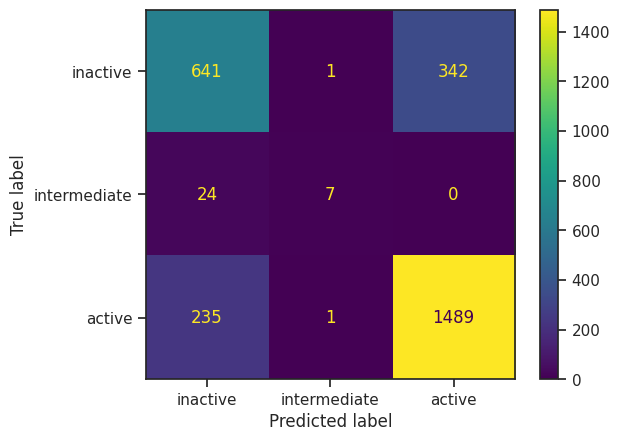

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


confusion_matrix_xgb = confusion_matrix(labeled_y_test, labeled_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_xgb, display_labels=np.array(['inactive', 'intermediate', 'active']))
disp.plot()
plt.show()

Accuracy Score

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labeled_y_test, labeled_y_pred)
print("Accuracy Score: ", accuracy*100, "%")

Accuracy Score:  77.99270072992701 %


**Getting the Top 20 Features (Molecular Descriptors)**

In [ ]:
feature_importance = model.feature_importances_

# Create a DataFrame to display the feature importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance
top20FeatureImp = feature_importance_df[:20]

Text(0.5, 1.0, 'Top 20 Important Features from XGBRegressor')

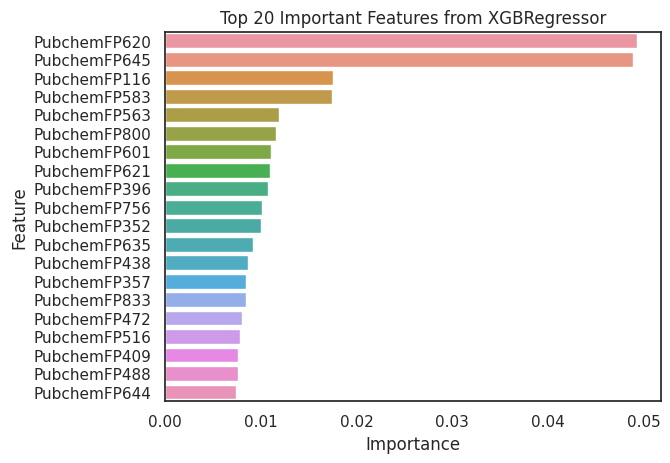

In [ ]:
sns.barplot(top20FeatureImp,x='Importance',y='Feature', orient = 'h')
plt.title("Top 20 Important Features from XGBRegressor")

In [ ]:
top20Features = top20FeatureImp['Feature']

In [ ]:
topFeaturesXTest_df = X_test[top20Features]
topFeaturesXTest_df['Label']= labeled_y_test
topFeaturesXTest_df

,PubchemFP620,PubchemFP645,PubchemFP116,PubchemFP583,PubchemFP563,PubchemFP800,PubchemFP601,PubchemFP621,PubchemFP396,PubchemFP756,...,PubchemFP635,PubchemFP438,PubchemFP357,PubchemFP833,PubchemFP472,PubchemFP516,PubchemFP409,PubchemFP488,PubchemFP644,Label
7847,1,1,1,0,0,0,0,0,1,0,...,0,1,0,0,1,1,0,0,0,1
11411,1,1,0,0,0,1,0,0,1,0,...,0,0,1,0,1,1,0,0,0,1
6778,1,1,1,0,0,1,1,1,1,0,...,0,0,0,0,1,1,0,0,0,1
6354,0,0,0,0,0,0,1,1,1,0,...,0,1,1,0,1,1,0,0,1,-1
13393,1,1,0,0,0,1,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13655,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,1,1,0,0,0,1
3408,0,0,0,0,0,0,1,1,1,0,...,0,1,0,0,1,1,0,0,0,-1
5778,1,1,0,0,0,0,1,1,1,1,...,1,1,1,0,1,1,0,0,1,1
7403,0,1,0,0,0,0,1,1,1,0,...,0,1,1,0,1,1,0,0,0,-1


Correlation of Presence of Chemical Substructure and Inhibitor Activity

In [ ]:
padelDescActivity = pd.DataFrame()
features = []
activity = []
for pubchem in topFeaturesXTest_df.columns[:-1]:
  count = 0
  total = 0
  for i in range(len(topFeaturesXTest_df)):

    if topFeaturesXTest_df.iloc[i]['Label'] == 1:
      total += 1
      if topFeaturesXTest_df.iloc[i][pubchem] == 1:
        count +=1

  features.append(pubchem)
  activity.append(count/total)
padelDescActivity['Features'] = features
padelDescActivity['Activity'] = activity

Text(0.5, 1.0, 'Correlation of Presence of Chemical Substructure and Inhibitor Activity')

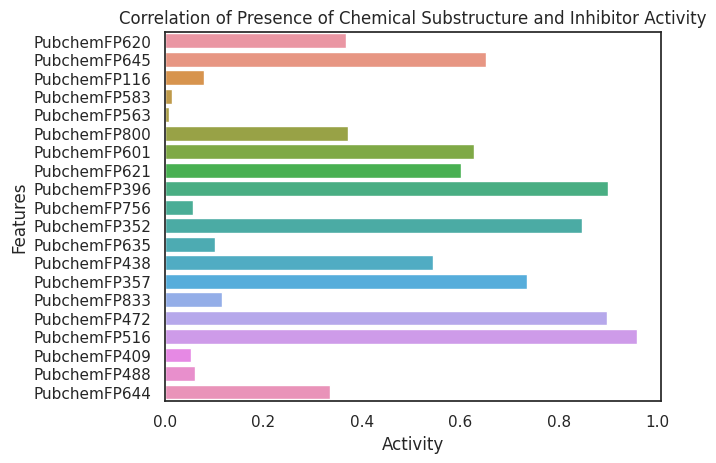

In [ ]:
sns.barplot(padelDescActivity,x='Activity',y='Features',orient='h')
plt.title("Correlation of Presence of Chemical Substructure and Inhibitor Activity")